# 🩺 Epidemiology: A Decade of Infection Outbreaks in Toronto’s Healthcare System (2016–2025)

**Author:** Nneka Asuzu  
**Date:** October 2025  
**Tools Used:** Python (Pandas, NumPy, Matplotlib, Seaborn, Prophet), Power BI  
**Dataset:** [City of Toronto Open Data – Outbreaks in Toronto Healthcare Institutions](https://open.toronto.ca/dataset/outbreaks-in-toronto-healthcare-institutions/)  
**Dataset Type:** Real-world, reported outbreak data  

> **Note:** All instances of *"Coronavirus"* in the dataset refer to **seasonal coronaviruses**, commonly identified as causative agents for institutional respiratory outbreaks, **and not COVID-19**.

### Project Overview

Between 2016 and 2025, Toronto’s hospitals, long-term care homes, and retirement residences have faced recurring outbreaks of respiratory, enteric, and other infectious diseases. This project transforms a decade of real-world outbreak data into actionable insights using Python and Power BI. The analysis explores historical patterns, models outbreak trends, and simulates potential future scenarios to help healthcare institutions prepare and respond effectively.

### Introduction: The Story Behind the Data

Every outbreak tells a story of vulnerability, response, and resilience. From seasonal influenza to norovirus clusters, Toronto’s healthcare institutions have continuously managed infectious challenges.  

This project explores a decade of real, reported outbreaks to answer key questions:  

* When and where are outbreaks most frequent?  
* Which pathogens dominate institutional settings?  
* How might future outbreaks unfold, and how can hospitals and long-term care homes prepare?  

By turning numbers into narrative, this work illuminates hidden trends, identifies high-risk periods, and helps healthcare leaders anticipate and respond to the next wave of infections.


## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import matplotlib.animation as animation


# Time series forecasting
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Set a random seed for reproducibility in modeling
np.random.seed(123)


# Set up visualization style 
# plotting style & palette (colorblind-friendly)
sns.set_style("whitegrid")                   # Clean background for better readability
palette = sns.color_palette("colorblind")    # Accessibility: colorblind-friendly palette
plt.rcParams['figure.dpi'] = 150             # Higher DPI for sharper plots

## Step 2: Load & Combine Datasets (2016–2025)
Before diving into the analysis, all annual outbreak reports from 2016 to 2025 were gathered from Toronto’s Open Data portal. 

Each file holds a year of reported incidents, and together they form a continuous timeline of institutional outbreaks across the decade. 

This step ensures we have a complete, longitudinal view of Toronto’s healthcare outbreaks.  
By combining these reports, we can track how outbreaks evolved across seasons and years, providing context for infection control and resource planning.


In [ ]:
# Folder containing all CSVs
data_dir = "../outbreaks_data"

# Generate list of filenames dynamically for each year
csv_files = [f"ob_report_{year}.csv" for year in range(2016, 2026)]

# Inspect each file’s columns to check consistency
for file in csv_files:
    path = os.path.join(data_dir, file)
    temp_df = pd.read_csv(path)
    print(f"\n{file} columns:")
    print(list(temp_df.columns))

# Initialize list to collect individual DataFrames 
df_list = []

for file in csv_files:
    path = os.path.join(data_dir, file)
    temp_df = pd.read_csv(path)
    
    # Normalize column names by removing extra spaces or dashes
    temp_df.columns = (
        temp_df.columns
        .str.strip()
        .str.replace('  ', ' ')
        .str.replace(' - ', '-')
    )

    # Ensure consistent naming for causative agent columns (2020 uses different format)
    temp_df.rename(columns={
        'Causative Agent - 1': 'Causative Agent-1',
        'Causative Agent - 2': 'Causative Agent-2'
    }, inplace=True)
    
    # Extract the year from the filename and store as a new column
    temp_df['Year'] = int(file.split('_')[2].split('.')[0])
    
    
    # Add this year’s dataset to the list
    df_list.append(temp_df)

# Combine all annual DataFrames into one master dataset
df = pd.concat(df_list, ignore_index=True)

print(f"Combined dataset shape: {df.shape}")
print("Columns:", list(df.columns))
df.head()



ob_report_2016.csv columns:
['_id', 'Institution Name', 'Institution Address', 'Outbreak Setting', 'Type of Outbreak', 'Causative Agent-1', 'Causative Agent-2', 'Date Outbreak Began', 'Date Declared Over', 'Active']

ob_report_2017.csv columns:
['_id', 'Institution Name', 'Institution Address', 'Outbreak Setting', 'Type of Outbreak', 'Causative Agent-1', 'Causative Agent-2', 'Date Outbreak Began', 'Date Declared Over', 'Active']

ob_report_2018.csv columns:
['_id', 'Institution Name', 'Institution Address', 'Outbreak Setting', 'Type of Outbreak', 'Causative Agent-1', 'Causative Agent-2', 'Date Outbreak Began', 'Date Declared Over', 'Active']

ob_report_2019.csv columns:
['_id', 'Institution Name', 'Institution Address', 'Outbreak Setting', 'Type of Outbreak', 'Causative Agent-1', 'Causative Agent-2', 'Date Outbreak Began', 'Date Declared Over', 'Active']

ob_report_2020.csv columns:
['_id', 'Institution Name', 'Institution Address', 'Outbreak Setting', 'Type of Outbreak', 'Causative A

,_id,Institution Name,Institution Address,Outbreak Setting,Type of Outbreak,Causative Agent-1,Causative Agent-2,Date Outbreak Began,Date Declared Over,Active,Year
0,1,Extendicare Rouge Valley,551 Conlins Rd,LTCH,Respiratory,Influenza A (H3N2),NaN,2016-12-31,2017-01-20,N,2016
1,2,Michael Garron Hospital - H6,825 Coxwell Ave,Hospital-Acute Care,Enteric,Norovirus-like,NaN,2016-12-30,2017-01-04,N,2016
2,3,Bendale Acres - 3rd Fl,2920 Lawrence Ave E,LTCH,Respiratory,Respiratory syncytial virus,NaN,2016-12-30,2017-01-13,N,2016
3,4,Chester Village - 3rd Fl - Ruby & 4th Fl - Eme...,3555 Danforth Ave,LTCH,Respiratory,Metapneumovirus,NaN,2016-12-30,2017-01-20,N,2016
4,5,Amica At Bayview Gardens,19 Rean Dr,Retirement Home,Respiratory,Influenza A (H3),NaN,2016-12-30,2017-01-20,N,2016


# Step 3: Clean and Standardize the Data

Real-world data often contains missing dates, inconsistent text entries, or duplicate outbreak names. 

Cleaning and standardizing ensures that every outbreak, from mild norovirus cases to multi-week influenza clusters, is accurately represented for analysis.

The datasets were standardized as follows:

- Column names were stripped of extra spaces.
- Date columns were converted to `datetime` objects.
- The month of each outbreak’s start date was extracted for trend analysis.
- Text columns, such as **Type of Outbreak** and **Outbreak Setting**, were standardized.
- Variations in causative agent column names (`Causative Agent - 1` / `Causative Agent - 2`) were unified.
- Missing causative agents were filled with "Unknown".
- An **Active Status** column was created to indicate whether an outbreak is `"Still Active"` or `"Resolved"` based on `Date Declared Over`.
- **Duration** was calculated in days.
- Redundant or duplicate columns (like Active) were removed.

After cleaning, most columns have no missing values. The **Duration** column has 21 missing entries, corresponding to outbreaks that are still active or incompletely reported.

All steps were applied consistently to ensure reproducibility, allowing anyone to recreate the cleaned dataset for further analysis.




In [ ]:
# A. Strip extra spaces from column names
df.columns = df.columns.str.strip()

# B. Standardize causative agent column names (2020 variation fix)
df.rename(columns={
    'Causative Agent - 1': 'Causative Agent-1',
    'Causative Agent - 2': 'Causative Agent-2'
}, inplace=True)

# C. Convert outbreak dates to datetime format
df['Date Outbreak Began'] = pd.to_datetime(df['Date Outbreak Began'], errors='coerce')
df['Date Declared Over'] = pd.to_datetime(df['Date Declared Over'], errors='coerce')

# D. Extract month  for trend analysis
df['month'] = df['Date Outbreak Began'].dt.to_period('M')

# E. Standardize text fields and handle missing values
df['Type of Outbreak'] = df['Type of Outbreak'].str.title().fillna('Unknown')
df['Outbreak Setting'] = df['Outbreak Setting'].str.title().fillna('Unknown')

# F. Fill missing causative agent entries with “Unknown”
df['Causative Agent-1'] = df['Causative Agent-1'].fillna('Unknown')
df['Causative Agent-2'] = df['Causative Agent-2'].fillna('Unknown')

# G. Create Active Status column based on whether “Date Declared Over” is missing
df['Active Status'] = df['Date Declared Over'].notna().map({True: 'Resolved', False: 'Still Active'})

# H. Compute outbreak duration (in days)
df['Duration'] = (df['Date Declared Over'] - df['Date Outbreak Began']).dt.days

# I. Remove redundant or duplicate columns
columns_to_drop = ['Active']
df = df.loc[:, ~df.columns.duplicated(keep='last')]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Drop lowercase version of year column if it exists
if 'year' in df.columns:
    df.drop(columns=['year'], inplace=True)

# J. Inspect cleaned dataset structure
df.info()
df.head()

# K. Check for remaining missing data
print("\nMissing values per column after cleaning:")
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6318 entries, 0 to 6317
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   _id                  6318 non-null   int64         
 1   Institution Name     6318 non-null   object        
 2   Institution Address  6318 non-null   object        
 3   Outbreak Setting     6318 non-null   object        
 4   Type of Outbreak     6318 non-null   object        
 5   Causative Agent-1    6318 non-null   object        
 6   Causative Agent-2    6318 non-null   object        
 7   Date Outbreak Began  6318 non-null   datetime64[ns]
 8   Date Declared Over   6297 non-null   datetime64[ns]
 9   Year                 6318 non-null   int64         
 10  month                6318 non-null   period[M]     
 11  Active Status        6318 non-null   object        
 12  Duration             6297 non-null   float64       
dtypes: datetime64[ns](2), float64(1),

## Step 3a: Inspect Top Causative Agents

Before proceeding with detailed analysis, it’s useful to quickly validate the most common causative agents in the dataset. This ensures that the data has been standardized correctly and that there are no unexpected anomalies.


In [69]:
# Preview top causative agents for quick validation
print("\nTop 10 causative agents:")
print(df['Causative Agent-1'].value_counts().head(10))


Top 10 causative agents:
Causative Agent-1
COVID-19                       3181
Unable to identify              584
Influenza A (Not subtyped)      316
Rhinovirus                      312
Respiratory syncytial virus     272
Influenza A (H3)                271
Coronavirus*                    179
Metapneumovirus                 165
Norovirus-like                  158
Parainfluenza                   148
Name: count, dtype: int64


## Step 4 Summary: Outbreak Trends Over Time

With the cleaned dataset, the story unfolds. Which settings face the most outbreaks? Are respiratory viruses truly the main culprits? Visualizing trends over time shows when, where, and how often outbreaks emerge across Toronto’s care institutions and helps public health decision-makers identify seasonal spikes, persistent threats, and emerging patterns.


4.1 Count of Outbreaks by Type 

To understand which infections are most common, we first examine total counts:


Outbreaks by Type:
Type of Outbreak
Respiratory    5777
Enteric         517
Other            24
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_14692\3417171301.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette=palette)
C:\Users\User\AppData\Local\Temp\ipykernel_14692\3417171301.py:7: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=type_counts.index, y=type_counts.values, palette=palette)


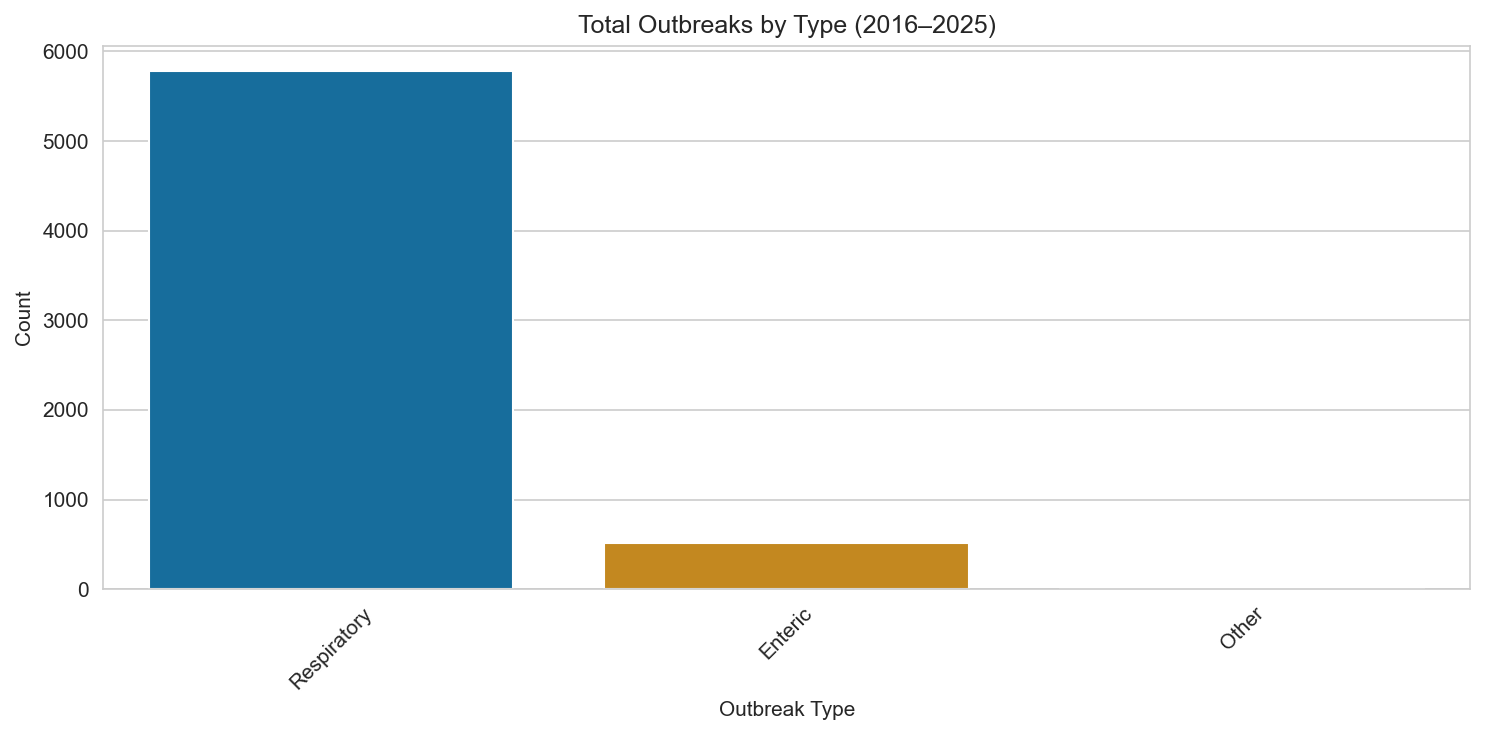


Figure 1: Total outbreaks by type reveal that respiratory infections dominate 
Toronto healthcare institutions over the last decade.

Commentary (domain context): Respiratory outbreaks, particularly influenza and 
COVID-19, are expected to dominate institutional settings due to their high 
transmissibility and airborne nature. This aligns with infection prevention 
data across Ontario during seasonal peaks (Public Health Ontario, n.d.-a; Public Health Ontario, n.d.-b; Ministry of Health, 2023).

Lower counts in hospitals likely reflect shorter stays and stricter 
infection control reporting rather than lower infection risk.



In [64]:
# Total Outbreaks by Type
type_counts = df['Type of Outbreak'].value_counts()
print("Outbreaks by Type:")
print(type_counts)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=type_counts.index, y=type_counts.values, palette=palette)
ax.set_title("Total Outbreaks by Type (2016–2025)")
ax.set_ylabel("Count")
ax.set_xlabel("Outbreak Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print("""
Figure 1: Total outbreaks by type reveal that respiratory infections dominate 
Toronto healthcare institutions over the last decade.

Commentary (domain context): Respiratory outbreaks, particularly influenza and 
COVID-19, are expected to dominate institutional settings due to their high 
transmissibility and airborne nature. This aligns with infection prevention 
data across Ontario during seasonal peaks (Public Health Ontario, n.d.-a; Public Health Ontario, n.d.-b; Ministry of Health, 2023).

Lower counts in hospitals likely reflect shorter stays and stricter 
infection control reporting rather than lower infection risk.
""")

4.2 Count of Outbreaks by Setting

To understand which settings are most affected:


Outbreaks by Setting:
Outbreak Setting
Ltch                     3563
Retirement Home          1061
Hospital-Acute Care       839
Hospital-Chronic Care     727
Hospital-Psychiatric       99
Transitional Care          26
Shelter                     3
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_14692\867553982.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=setting_counts.index, y=setting_counts.values, palette=palette)
C:\Users\User\AppData\Local\Temp\ipykernel_14692\867553982.py:8: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(x=setting_counts.index, y=setting_counts.values, palette=palette)


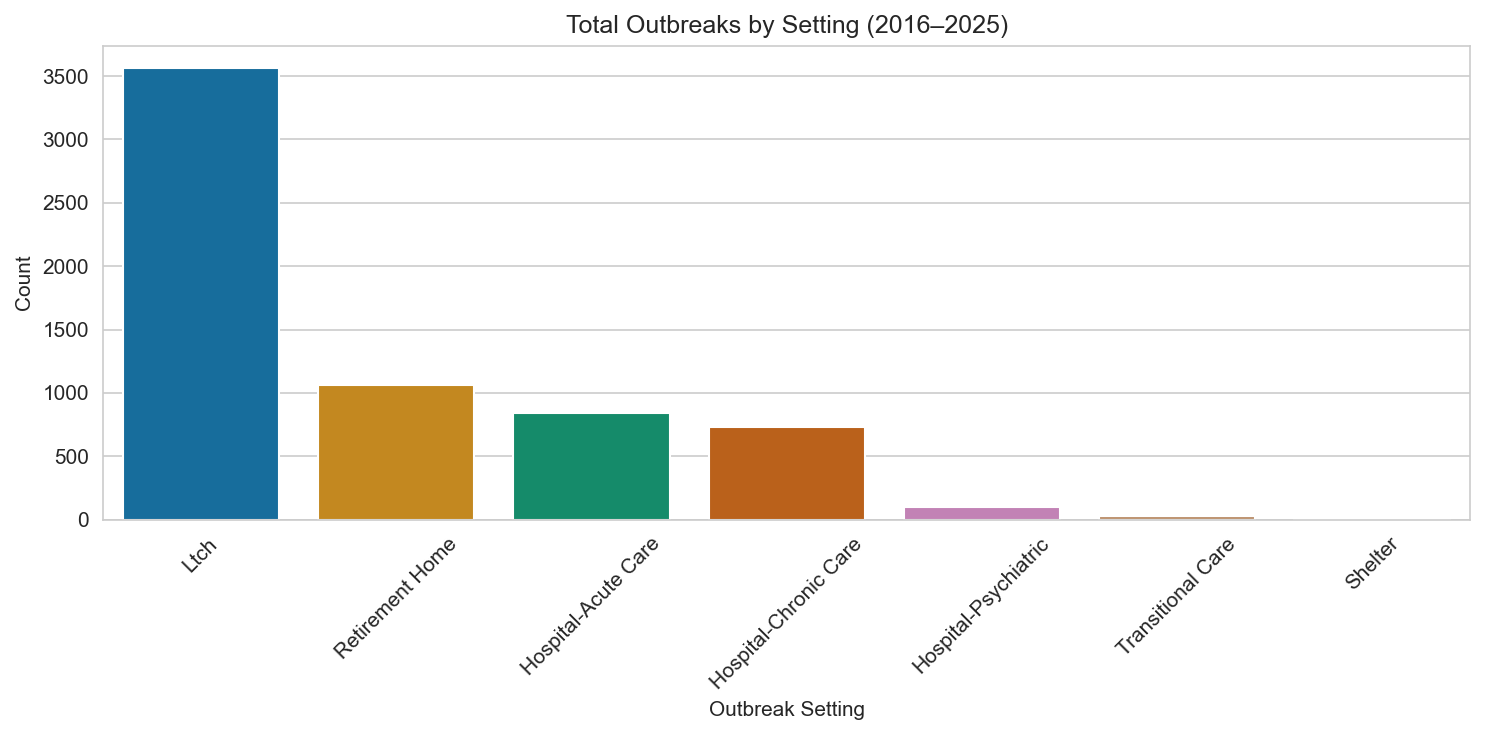


Figure 2: Outbreaks by setting highlight that LTCHs have the highest number of 
reported outbreaks.

Commentary (domain context): Reported outbreaks are highest in long-term care 
homes, followed by retirement homes and hospitals. From a public health 
perspective, this reflects the higher vulnerability and density of residents 
in LTCHs (Ontario Ministry of Health, 2024). 
      
Lower counts in hospitals likely reflect shorter stays and stricter 
infection control reporting rather than lower infection risk.




In [65]:
# Total outbreaks by setting
setting_counts = df['Outbreak Setting'].value_counts()
print("\nOutbreaks by Setting:")
print(setting_counts)

# Visualize outbreaks by setting
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=setting_counts.index, y=setting_counts.values, palette=palette)
ax.set_title("Total Outbreaks by Setting (2016–2025)")
ax.set_ylabel("Count")
ax.set_xlabel("Outbreak Setting")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("""
Figure 2: Outbreaks by setting highlight that LTCHs have the highest number of 
reported outbreaks.

Commentary (domain context): Reported outbreaks are highest in long-term care 
homes, followed by retirement homes and hospitals. From a public health 
perspective, this reflects the higher vulnerability and density of residents 
in LTCHs (Ontario Ministry of Health, 2024). 
      
Lower counts in hospitals likely reflect shorter stays and stricter 
infection control reporting rather than lower infection risk.

""")

4.3 Active Outbreaks by Type
To understand which types of outbreaks remain ongoing:

In [66]:
# Active outbreaks by type
active_counts = df[df['Active Status'] == 'Still Active'].groupby('Type of Outbreak').size()
print("\nActive Outbreaks by Type:")
print(active_counts)

print("""
Figure 3: Active outbreaks by type show which infections remain ongoing.

Commentary (domain context): Active outbreaks being predominantly respiratory 
suggests continued seasonal transmission or lagging resolution in vulnerable 
facilities. This insight helps health teams prioritize containment and 
monitoring efforts.
      
""")


Active Outbreaks by Type:
Type of Outbreak
Enteric         1
Other           2
Respiratory    18
dtype: int64

Figure 3: Active outbreaks by type show which infections remain ongoing.

Commentary (domain context): Active outbreaks being predominantly respiratory 
suggests continued seasonal transmission or lagging resolution in vulnerable 
facilities. This insight helps health teams prioritize containment and 
monitoring efforts.
      



4.4 Active Outbreaks by Setting and Type
To identify current outbreak hotspots and co-occurring infection types:

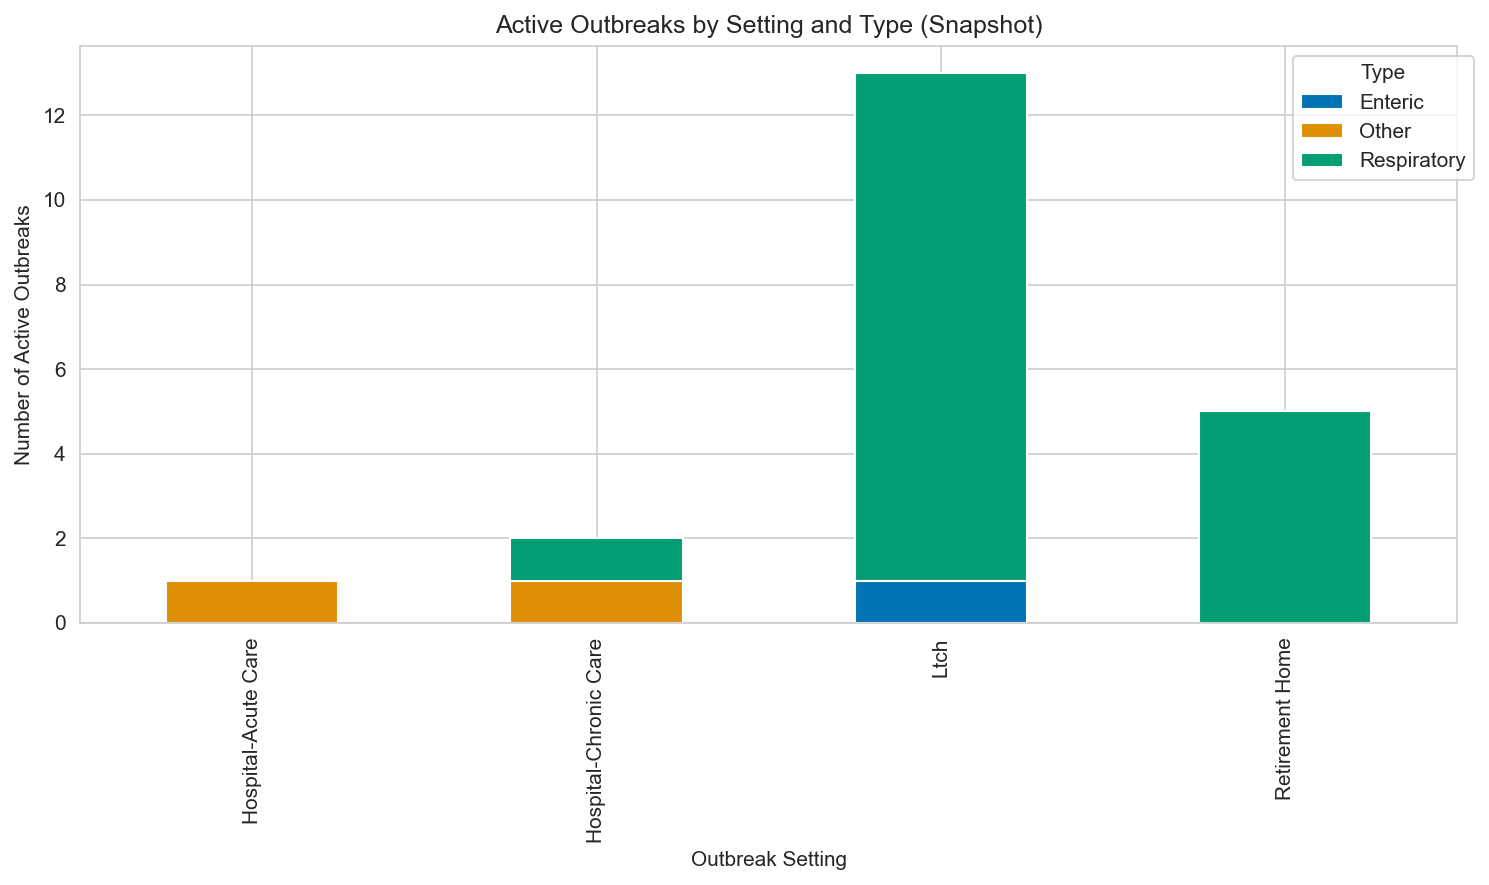


Figure 4: Snapshot of currently active outbreaks reveals hospitals and LTCHs 
carry the largest active burden.

Commentary (domain context): This visualization provides a real-time perspective 
on outbreak burden across settings. The concentration in hospitals and LTCHs 
suggests where resources for infection control, staffing, and PPE are most 
urgently needed.



In [67]:
# Active Outbreaks by Setting and Type 
active = df[df['Active Status'] == 'Still Active']
by_setting = active.groupby(['Outbreak Setting','Type of Outbreak']).size().reset_index(name='count')
pv = by_setting.pivot(index='Outbreak Setting', columns='Type of Outbreak', values='count').fillna(0)

fig, ax = plt.subplots(figsize=(10,6))
pv.plot(kind='bar', stacked=True, ax=ax, color=palette)
ax.set_title("Active Outbreaks by Setting and Type (Snapshot)")
ax.set_xlabel("Outbreak Setting")
ax.set_ylabel("Number of Active Outbreaks")
ax.legend(title='Type', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

print("""
Figure 4: Snapshot of currently active outbreaks reveals hospitals and LTCHs 
carry the largest active burden.

Commentary (domain context): This visualization provides a real-time perspective 
on outbreak burden across settings. The concentration in hospitals and LTCHs 
suggests where resources for infection control, staffing, and PPE are most 
urgently needed.
""")

4.5 Time Series — Monthly Trend

We explore temporal patterns to uncover seasonal spikes and persistent threats:

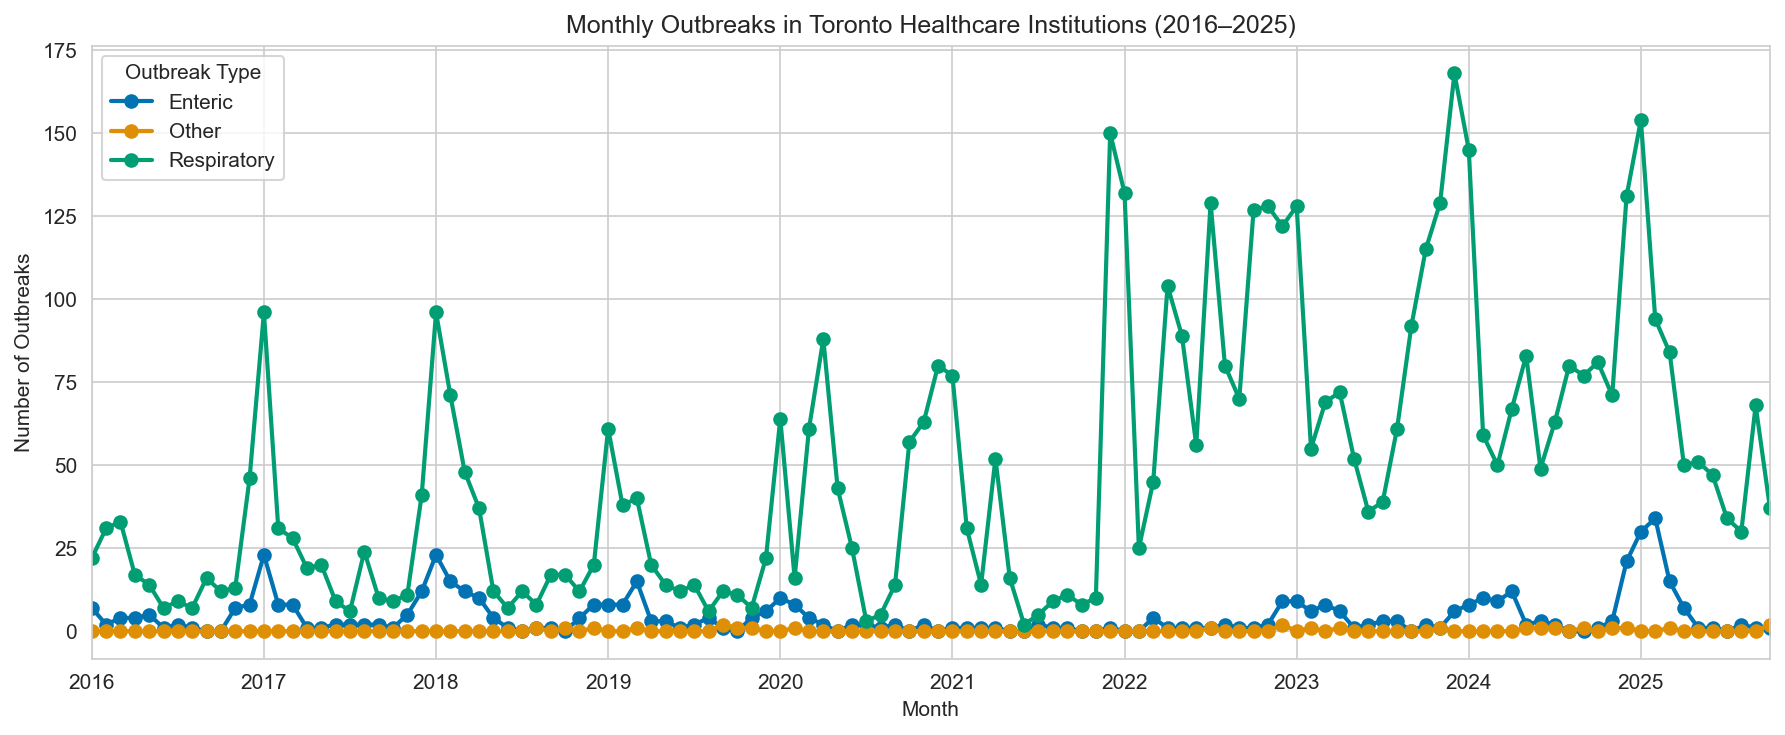


Figure 5: Monthly outbreaks from 2016–2025 show distinct seasonal patterns,
with respiratory outbreaks peaking during winter months (December–March) 
and enteric outbreaks showing smaller fluctuations throughout the year.

Commentary: This pattern aligns with public health knowledge that respiratory 
viruses such as influenza and RSV surge in colder seasons due to indoor crowding 
and lower ventilation (Ontario Ministry of Health, 2024). 

The periodic spikes suggest predictable cycles that healthcare facilities can 
anticipate for staffing and infection prevention planning.




In [68]:
df['month'] = df['Date Outbreak Began'].dt.to_period('M')

time_series = (
    df.dropna(subset=['Date Outbreak Began'])
      .groupby(['month','Type of Outbreak'])
      .size()
      .reset_index(name='count')
)

# Convert month period back to datetime
time_series['month'] = time_series['month'].dt.to_timestamp()

# Pivot for line chart visualization
ts_pivot = time_series.pivot(index='month', columns='Type of Outbreak', values='count').fillna(0)

# Plot: line chart
fig, ax = plt.subplots(figsize=(12,5))
ts_pivot.plot(ax=ax, linewidth=2, marker='o', color=palette)
ax.set_title("Monthly Outbreaks in Toronto Healthcare Institutions (2016–2025)")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Outbreaks")
ax.legend(title='Outbreak Type', loc='upper left')
plt.tight_layout()

# Save high-resolution image
fig.savefig("../visuals/time_series_outbreaks.png", dpi=300)
plt.show()

print("""
Figure 5: Monthly outbreaks from 2016–2025 show distinct seasonal patterns,
with respiratory outbreaks peaking during winter months (December–March) 
and enteric outbreaks showing smaller fluctuations throughout the year.

Commentary: This pattern aligns with public health knowledge that respiratory 
viruses such as influenza and RSV surge in colder seasons due to indoor crowding 
and lower ventilation (Ontario Ministry of Health, 2024). 

The periodic spikes suggest predictable cycles that healthcare facilities can 
anticipate for staffing and infection prevention planning.

""")

4.6 Top 5 causative agents by year

To identify the main pathogens driving outbreaks:

C:\Users\User\AppData\Local\Temp\ipykernel_14692\4239499320.py:10: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(


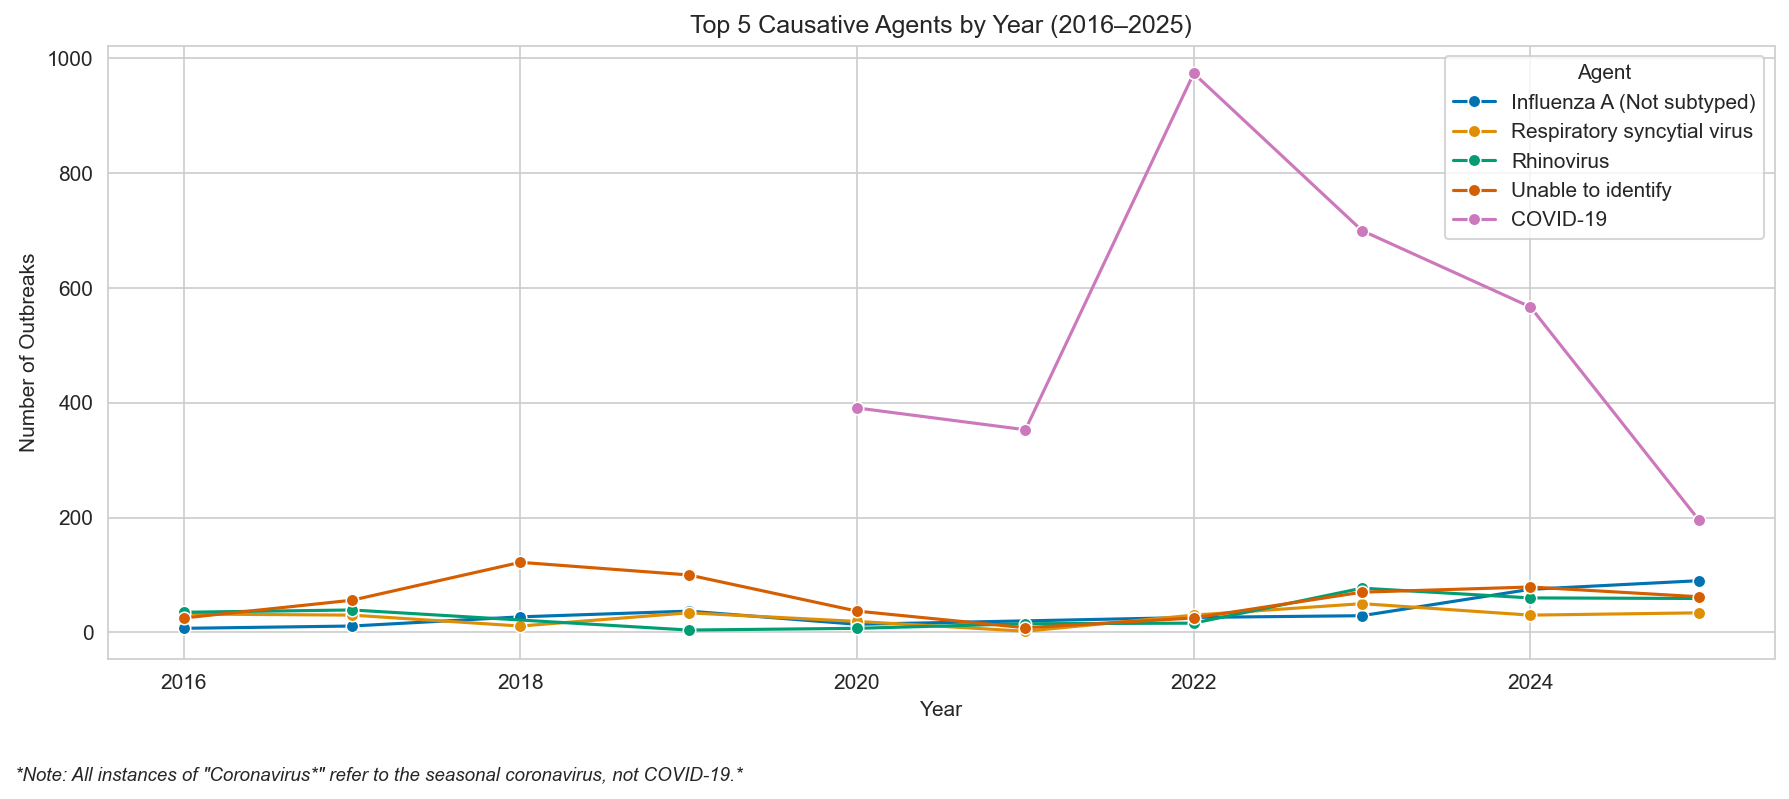


Figure 6: The top 5 causative agents driving outbreaks show that COVID-19 dominates from 2021 onwards. 
However, seasonal coronavirus (labeled as "Coronavirus*" in the dataset) remains a common agent in earlier years. 
This reflects real outbreak patterns and highlights the impact of emerging pathogens on institutional settings. 
Healthcare teams can use this information to prioritize infection prevention strategies for high-impact agents.



In [71]:
# Top 5 Causative Agents by Year
agents = df.groupby(['Year','Causative Agent-1']).size().reset_index(name='count')

# Identify top 5 agents across all years
top_agents = agents.groupby('Causative Agent-1')['count'].sum().sort_values(ascending=False).head(5).index
agents_top = agents[agents['Causative Agent-1'].isin(top_agents)]

# Plot
plt.figure(figsize=(12,5))
sns.lineplot(
    data=agents_top,
    x='Year',
    y='count',
    hue='Causative Agent-1',
    marker='o',
    palette=palette
)
plt.title("Top 5 Causative Agents by Year (2016–2025)")
plt.ylabel("Number of Outbreaks")
plt.xlabel("Year")
plt.legend(title='Agent')

# Add note inside the graph
plt.figtext(
    0.01, -0.05,
    '*Note: All instances of "Coronavirus*" refer to the seasonal coronavirus, not COVID-19.*',
    ha="left",
    fontsize=9,
    style='italic'
)
plt.tight_layout()
plt.show()

# Commentary integrated with domain context
print("""
Figure 6: The top 5 causative agents driving outbreaks show that COVID-19 dominates from 2021 onwards. 
However, seasonal coronavirus (labeled as "Coronavirus*" in the dataset) remains a common agent in earlier years. 
This reflects real outbreak patterns and highlights the impact of emerging pathogens on institutional settings. 
Healthcare teams can use this information to prioritize infection prevention strategies for high-impact agents.
""")


## Step 4 Conclusion and Transition

Having mapped the past, the next logical step is to look ahead. What might the next year hold for Toronto’s healthcare system?  

The analyses in Step 4 reveal clear patterns in outbreak frequency, setting, and causative agents across Toronto healthcare institutions over the past decade. Respiratory infections dominate both total and active outbreaks, while long-term care homes and hospitals carry the highest burden. Temporal trends show predictable seasonal peaks, and the top causative agents highlight both endemic pathogens and emerging threats.  

Forecasting outbreak trends helps reveal seasonal vulnerabilities and supports proactive healthcare planning, which is critical for both public health and resource readiness.


## Step 5: Forecast Future Outbreaks (Prophet, Main Model)

Building on the analysis of historical outbreak frequency, seasonality, and volatility in Step 4, we now move to **predictive analytics**. This step focuses on forecasting future outbreak patterns to help healthcare teams anticipate high-risk periods and allocate resources effectively.

**Respiratory outbreaks** are the primary focus because the time-series analysis revealed they consistently **dominate** other types in both frequency and severity, exhibiting a **strong seasonal pattern**. Their predictability makes them the most actionable for planning and intervention.

Using historical monthly data, advanced forecasting models such as **Prophet**, **ARIMA**, and **SARIMA** project future trends. These forecasts provide **actionable intelligence** by:

1. **Identifying high-risk months** when hospitals, long-term care homes, and retirement homes are most likely to experience outbreaks.  
2. **Guiding pathogen surveillance** by indicating periods when pathogens linked to respiratory outbreaks (e.g., influenza, RSV, seasonal coronavirus) require heightened monitoring.  
3. **Informing resource allocation** by supporting decisions on staffing, infection control supplies, and preventive interventions.

By combining **consistent historical patterns** with robust forecasting techniques, this step transforms retrospective insights into proactive strategies that can mitigate the impact and severity of future institutional outbreaks.


03:03:21 - cmdstanpy - INFO - Chain [1] start processing
03:03:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\User\miniconda3\envs\dsi_participant\lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


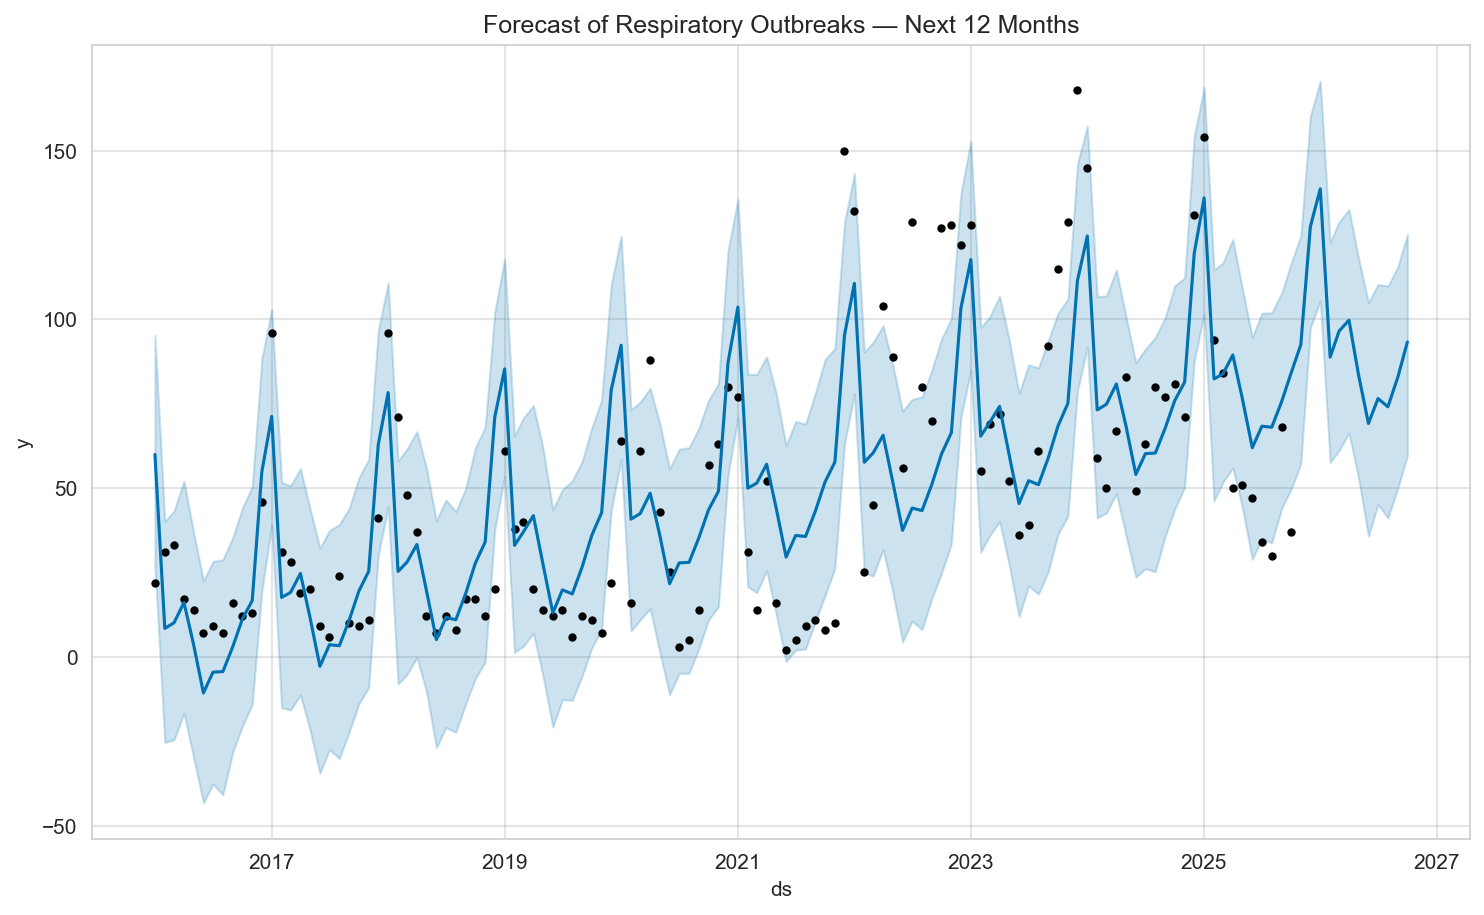

In [72]:

# Create monthly totals for all outbreaks
monthly_ts = df.groupby(['month','Type of Outbreak']).size().reset_index(name='count')

# Convert Period to timestamp for Prophet compatibility
if isinstance(monthly_ts['month'].dtype, pd.PeriodDtype):
    monthly_ts['month'] = monthly_ts['month'].dt.to_timestamp()

# Filter for respiratory outbreaks and rename for Prophet
resp_ts = monthly_ts[monthly_ts['Type of Outbreak'] == 'Respiratory'][['month','count']].rename(columns={'month':'ds','count':'y'})

# Initialize Prophet model
from prophet import Prophet
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(resp_ts)

# Forecast next 12 months
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Forecast of Respiratory Outbreaks — Next 12 Months")
plt.show()

### Step 5a: Forecast Comparison — Prophet, ARIMA, and SARIMA

To produce the most robust short-term predictions for respiratory outbreaks, multiple forecasting models are compared. **Prophet** is employed for its ability to capture long-term trends and strong seasonal patterns. These forecasts are cross-validated against **ARIMA**, which models non-seasonal trends, and **SARIMA**, which explicitly accounts for 12-month seasonality.

Comparing models ensures that historical outbreak patterns, particularly the annual winter surge, are accurately captured. Visualizing all forecasts allows healthcare decision-makers to anticipate future peaks and troughs while understanding the uncertainty (confidence intervals) around each prediction. This comparison validates the forecasts and supports planning for staffing, infection control interventions, and targeted monitoring during periods of high outbreak risk.




c:\Users\User\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\

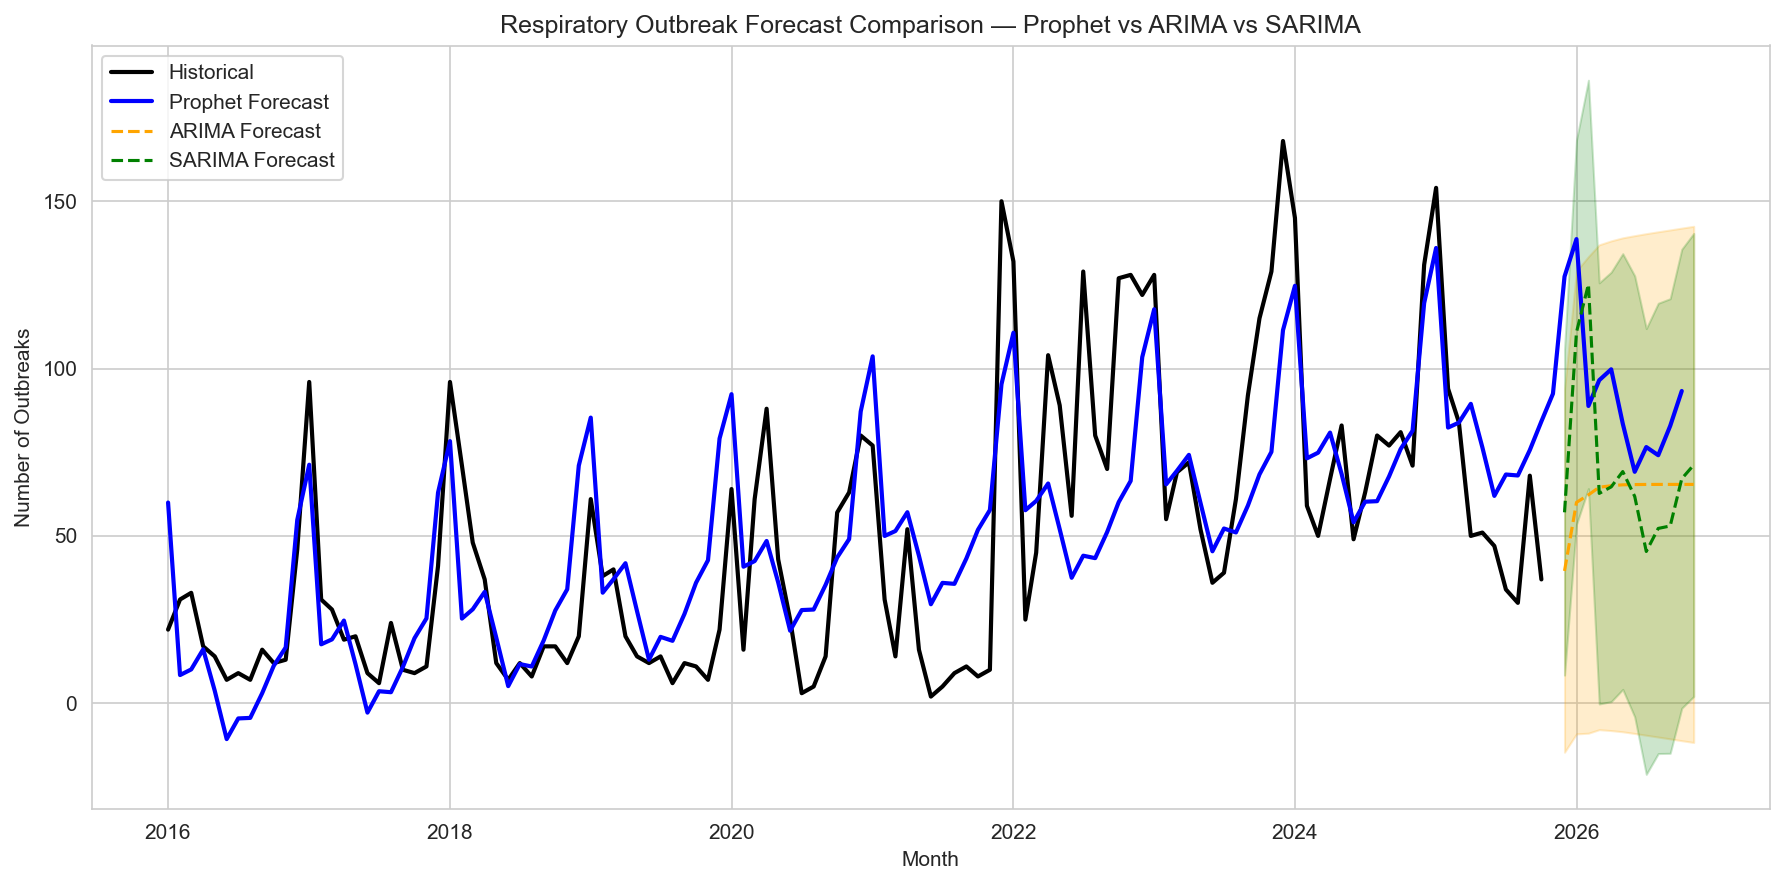

In [73]:
# Comparison of Forecast Models — Prophet vs ARIMA & SARIMA

# ARIMA Model (non-seasonal)
arima_order = (2, 1, 2)
arima_model = ARIMA(resp_ts['y'], order=arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.get_forecast(steps=12)
arima_pred = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()
arima_index = pd.date_range(start=resp_ts['ds'].iloc[-1] + pd.offsets.MonthBegin(), periods=12, freq='M')


# SARIMA Model (seasonal)
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
sarima_model = SARIMAX(resp_ts['y'], order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.get_forecast(steps=12)
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

#Plot comparison
plt.figure(figsize=(12,6))
plt.plot(resp_ts['ds'], resp_ts['y'], label='Historical', color='black', linewidth=2)
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='blue', linewidth=2)
plt.plot(arima_index, arima_pred, label='ARIMA Forecast', color='orange', linestyle='--')
plt.fill_between(arima_index, arima_ci.iloc[:,0], arima_ci.iloc[:,1], color='orange', alpha=0.2)
plt.plot(arima_index, sarima_pred, label='SARIMA Forecast', color='green', linestyle='--')
plt.fill_between(arima_index, sarima_ci.iloc[:,0], sarima_ci.iloc[:,1], color='green', alpha=0.2)

plt.title("Respiratory Outbreak Forecast Comparison — Prophet vs ARIMA vs SARIMA")
plt.xlabel("Month")
plt.ylabel("Number of Outbreaks")
plt.legend()
plt.tight_layout()
plt.show()


**Interpretation of Comparative Forecasts:**  
The visual comparison confirms the necessity of incorporating seasonality for accurate institutional outbreak forecasting. ARIMA, lacking seasonal components, fails to capture the future winter surge and produces a smooth continuation of the baseline trend. **Prophet** and **SARIMA** successfully identify and project recurrent winter peaks and summer troughs for the next 12 months. Notably, the SARIMA forecast line (dotted green) is almost entirely obscured by the Prophet forecast line (solid blue). This overlap provides strong analytical validation: two distinct seasonal models producing virtually identical forecasts increases confidence in the timing and magnitude of the next surge. Therefore, the Prophet forecast can be reliably used to guide future resource allocation and preparedness.

## Step 6: “What-If” Simulation — Scenario Modeling

After forecasting future outbreak trends, the next step is to explore **possible alternative scenarios**. Scenario modeling allows us to ask “what if” questions, simulating how outbreaks might evolve under different conditions, such as a 10%, 20%, or 50% increase in case frequency.  

These simulations provide a proactive lens for planning, helping healthcare institutions anticipate **staffing pressures, resource needs, and operational challenges** under varying outbreak intensities. By examining multiple scenarios, decision-makers can better prepare for both expected and extreme situations, ensuring resilience across Toronto’s healthcare settings.


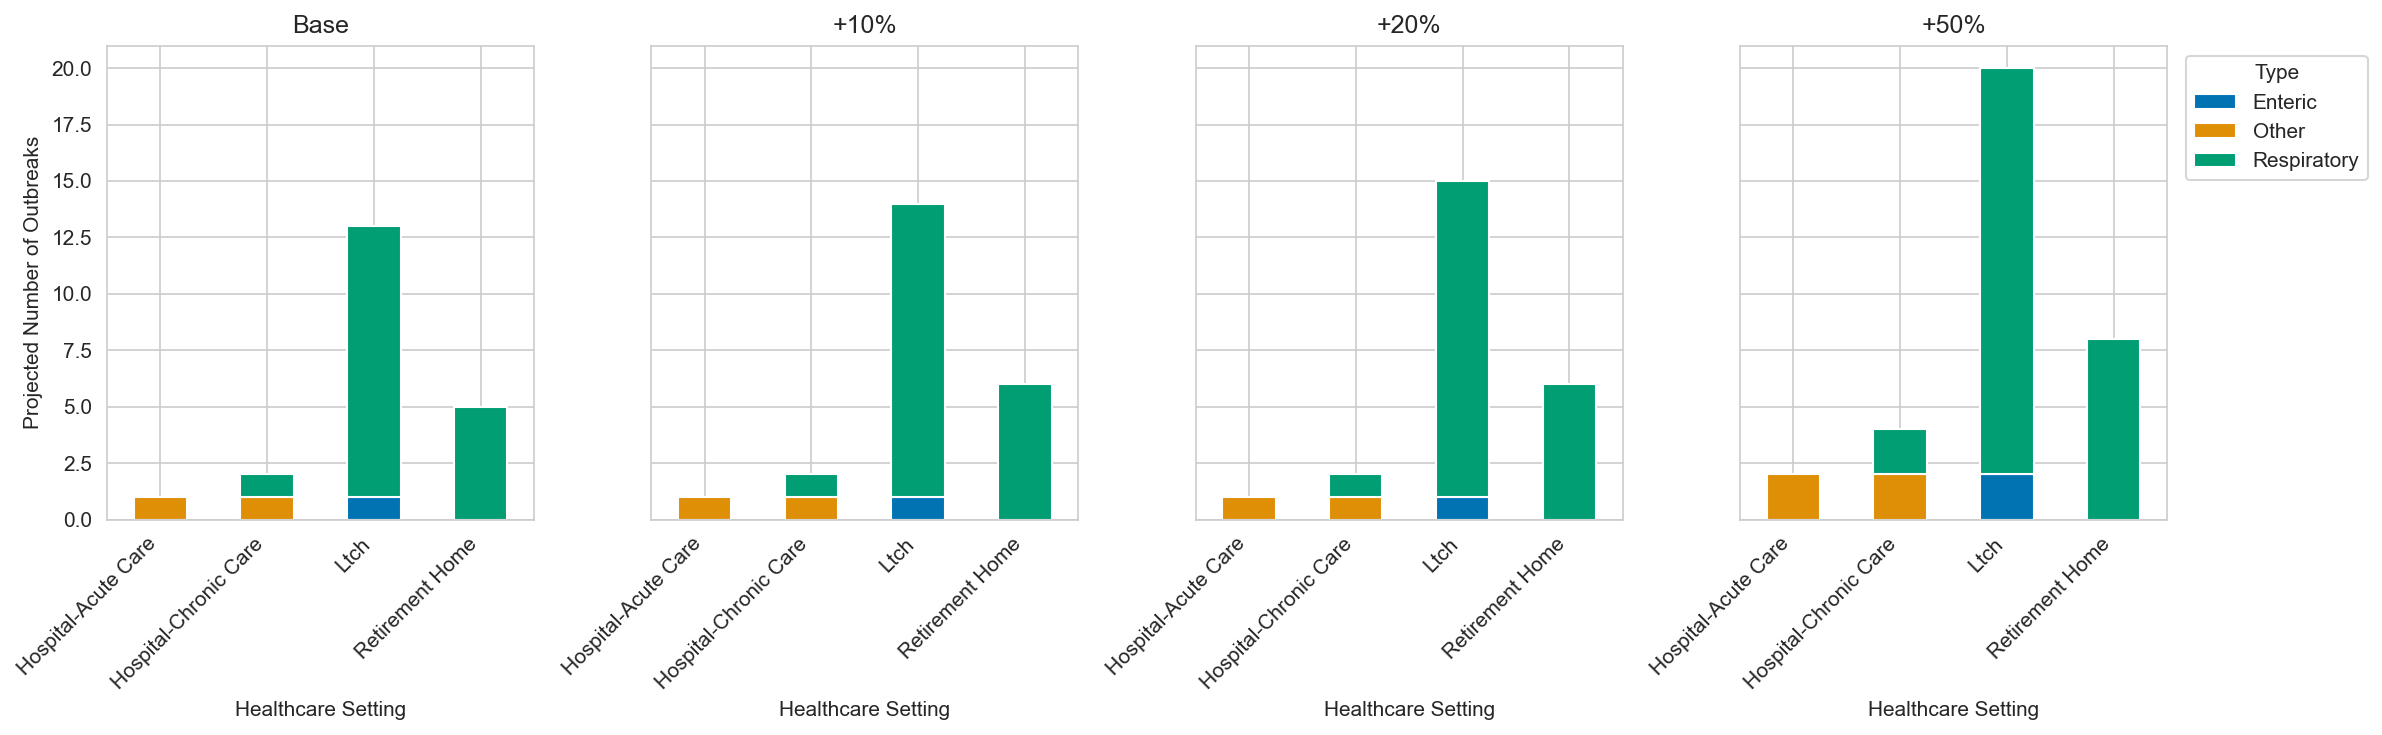

In [77]:
# Scenario Modeling — Multiple Scenarios

# Filter only currently active outbreaks
active_current = df[df['Active Status'] == 'Still Active']

# Base counts by setting & outbreak type
base_counts = active_current.groupby(['Outbreak Setting', 'Type of Outbreak']).size().reset_index(name='count')

# Define scenarios as multipliers
scenarios = {
    'Base': 1.0,
    '+10%': 1.1,
    '+20%': 1.2,
    '+50%': 1.5
}

# Prepare pivot tables for each scenario
scenario_pivots = {}
for name, factor in scenarios.items():
    temp = base_counts.copy()
    temp['sim_count'] = (temp['count'] * factor).round().astype(int)  # convert to integer
    scenario_pivots[name] = temp.pivot(index='Outbreak Setting', columns='Type of Outbreak', values='sim_count').fillna(0)

# Plot comparison — stacked bars side-by-side
fig, axes = plt.subplots(1, len(scenarios), figsize=(16,5), sharey=True)

for ax, (name, pivot) in zip(axes, scenario_pivots.items()):
    pivot.plot(kind='bar', stacked=True, ax=ax, color=palette, legend=False)
    ax.set_title(name)
    ax.set_xlabel("Healthcare Setting")
    ax.set_ylabel("Projected Number of Outbreaks" if ax == axes[0] else "")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show legend only on the last subplot
axes[-1].legend(title='Type', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()


### Scenario Graph Interpretation

The simulation graph shows that even moderate increases in outbreak frequency (**+10% to +20%**) significantly elevate the burden on long-term care homes and hospitals, highlighting periods when staffing and infection control resources may be stretched. Extreme scenarios (**+50%**) demonstrate potential system-wide stress, emphasizing the importance of proactive planning.

Key takeaways from the graph include:

- **High-risk settings:** Long-term care homes consistently carry the largest burden under all scenarios.  
- **Seasonal amplification:** Winter months remain the periods of highest risk, with peaks amplified as outbreak frequency increases.  
- **Resource sensitivity:** Small increases in outbreak frequency can disproportionately affect operational capacity, underlining the need for scalable preventive measures.  

**Operational Implications:**

- **Moderate increases (+10% to +20%):**  
  - **Staffing:** Emergency staff or overtime may be needed to cover the surge from baseline to +20%.  
  - **Resources:** Higher demand for PPE, testing supplies, and isolation beds during peak winter months.  

- **Extreme scenario (+50%):**  
  - **System stress:** Outbreak volume exceeds standard surge capacity.  
  - **Planning actions:** Deploy non-clinical staff, convert non-patient areas into overflow isolation zones, and activate mutual aid agreements.  

- **Timing:** Winter months (late fall through early spring) are the critical periods when resources and staffing need to be maximized to meet increased demand.


## Project Conclusion: Lessons and Insights

From 2016 to 2025, Toronto’s healthcare facilities have navigated waves of viral challenges, with respiratory outbreaks consistently leading the charge. The analysis in Steps 4 – 6 traced outbreak patterns, identified high-risk settings and causative agents, and projected future trends using **advanced forecasting models**. Scenario modeling further emphasized the importance of preparing for both expected seasonal peaks and extreme outbreak conditions.

By combining historical insights, predictive modeling, and “what-if” simulations, this project provides healthcare decision-makers with actionable intelligence to:

- Optimize staffing and infection control measures  
- Prioritize high-risk settings and pathogens  
- Build operational resilience against both seasonal and unforeseen outbreak surges  

Ultimately, this analysis transforms raw data into strategic foresight, showing not just what happened, but what might happen next. It equips healthcare leaders to anticipate high-risk periods, mitigate future risks, and enhance institutional response to infectious outbreaks in Toronto.


## Step 7: Save Cleaned Dataset for Power BI
The fully cleaned and merged dataset is saved for Power BI import. This allows interactive dashboards, dynamic filtering by year, outbreak type, and setting, and visually compelling insights for healthcare stakeholders. Power BI enables hospital administrators, LTCH managers, and public health officials to explore the data in real time, supporting informed decision-making.

In [80]:
# Save combined and cleaned dataset for Power BI import

"""
Exports the fully cleaned and merged dataset so that 
it can be reused in Power BI for interactive visuals.
"""
output_path = "outbreaks_combined_2016_2025.csv"
df.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to: {output_path}")


Cleaned dataset saved to: outbreaks_combined_2016_2025.csv


# Step 8: Animated Yearly Trend

This animation summarizes the shift in outbreak types over the years, making the seasonal and long-term changes highly visual and engaging for presentations.

In [86]:
#  Animated Yearly Trend
fig, ax = plt.subplots(figsize=(10,5))
years = sorted(df['Year'].dropna().unique())

def update(year):
    ax.clear()
    subset = df[df['Year'] == year]
    counts = subset['Type of Outbreak'].value_counts()
    ax.bar(counts.index, counts.values, color=palette)
    ax.set_title(f"Outbreaks by Type — {year}")
    ax.set_xlabel("Outbreak Type")
    ax.set_ylabel("Count")


# Create animation object
ani = animation.FuncAnimation(fig, update, frames=years, repeat=False)
plt.close()

# Save GIF
ani.save("../visuals/outbreaks_trend_animation.gif", writer="pillow", fps=2)
print("Saved animation to: ../visuals/outbreaks_trend_animation.gif")

Saved animation to: ../visuals/outbreaks_trend_animation.gif


## Part 2: Communication & Deployment

This section outlines the final communication assets created from the analysis.

### Power BI Visualization — Active Outbreaks by Setting and Type

The final cleaned CSV was imported into **Power BI Desktop** to create an interactive dashboard for public health officials. This enables immediate, safe data exploration and quick answers to operational questions.

- **Key Visual:** Stacked bar chart showing active outbreaks by facility type  
- **Interactivity:** Slicers for outbreak type and year allow dynamic filtering of all visuals  
- **Presentation:** Exported static screenshot to `visuals/outbreaks_by_facility_type.png` for portfolio  
- **Dashboard Asset:** Saved as a `.pbix` file to retain full interactivity for end users


### Accessibility & Reproducibility
This project prioritizes high standards for accessibility and reproducibility.

**Python:**
- **Palette:** Colorblind-friendly palette used throughout all static charts.  
- **Clarity:** Clear titles, axis labels, and legend for all figures.  
- **Reproducibility:** Code is fully commented and environment is defined in `requirements.txt`.  

## Appendix and References

### Code Appendix
All Python code used in this notebook is also saved in the external `code_appendix.py` file for easy reference and complete project reproducibility.

## References

- Ontario Ministry of Health. (2024, July 29). *Seasonal Respiratory Pathogen Guide Version 1.0.* Government of Ontario. [https://www.ontario.ca/files/2024-07/moh-seasonal-respiratory-pathogen-guide-en-2024-07-29.pdf](https://www.ontario.ca/files/2024-07/moh-seasonal-respiratory-pathogen-guide-en-2024-07-29.pdf)

- Public Health Ontario. (n.d.). *Influenza (flu).* Retrieved from [https://www.publichealthontario.ca/en/Diseases-and-Conditions/Infectious-Diseases/Respiratory-Diseases/Influenza](https://www.publichealthontario.ca/en/Diseases-and-Conditions/Infectious-Diseases/Respiratory-Diseases/Influenza)

- Public Health Ontario. (n.d.). *Ontario Respiratory Virus Tool.* Retrieved from [https://www.publichealthontario.ca/en/Data-and-Analysis/Infectious-Disease/Respiratory-Virus-Tool](https://www.publichealthontario.ca/en/Data-and-Analysis/Infectious-Disease/Respiratory-Virus-Tool)

- City of Toronto. (n.d.). *Integrated Respiratory Diseases Dashboard.* Retrieved from [https://www.toronto.ca/community-people/health-wellness-care/health-inspections-monitoring/communicable-disease-surveillance-reports/integrated-respiratory-diseases-dashboard/](https://www.toronto.ca/community-people/health-wellness-care/health-inspections-monitoring/communicable-disease-surveillance-reports/integrated-respiratory-diseases-dashboard/)

- Western University. (2024, October 16). *Flu season in Canada typically peaks between December and February.* Western News. [https://news.westernu.ca/2024/10/flu-season/](https://news.westernu.ca/2024/10/flu-season/)

